<a href="https://colab.research.google.com/github/walidhbabou/dockerProjetAI/blob/main/Bienvenue_dans_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F



In [ ]:
# Load the dataset
df = pd.read_csv("/content/User0_credit_card_transactions.csv")

# Check the number of rows in the dataset
print(f"Number of rows in dataset: {df.shape[0]}")

# If the dataset has fewer rows than the desired sample size, adjust the sample size
sample_size = min(100000, df.shape[0])
df_sampled = df.sample(n=sample_size, random_state=42)

# Continue with your work


Number of rows in dataset: 19963


In [ ]:


df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19963 entries, 0 to 19962
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            19963 non-null  int64  
 1   Card            19963 non-null  int64  
 2   Year            19963 non-null  int64  
 3   Month           19963 non-null  int64  
 4   Day             19963 non-null  int64  
 5   Time            19963 non-null  object 
 6   Amount          19963 non-null  object 
 7   Use Chip        19963 non-null  object 
 8   Merchant Name   19963 non-null  int64  
 9   Merchant City   19963 non-null  object 
 10  Merchant State  18646 non-null  object 
 11  Zip             18316 non-null  float64
 12  MCC             19963 non-null  int64  
 13  Errors?         574 non-null    object 
 14  Is Fraud?       19963 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.3+ MB


In [ ]:


# We need to make sure that the samples we extracted have some rows where fraud is True
df [df['Is Fraud?'] == 'Yes'].shape



(27, 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Zip'),
  Text(2, 0, 'Merchant State'),
  Text(3, 0, 'User'),
  Text(4, 0, 'Card'),
  Text(5, 0, 'Year'),
  Text(6, 0, 'Month'),
  Text(7, 0, 'Day'),
  Text(8, 0, 'Time'),
  Text(9, 0, 'Amount'),
  Text(10, 0, 'Use Chip'),
  Text(11, 0, 'Merchant Name'),
  Text(12, 0, 'Merchant City'),
  Text(13, 0, 'MCC'),
  Text(14, 0, 'Is Fraud?')])

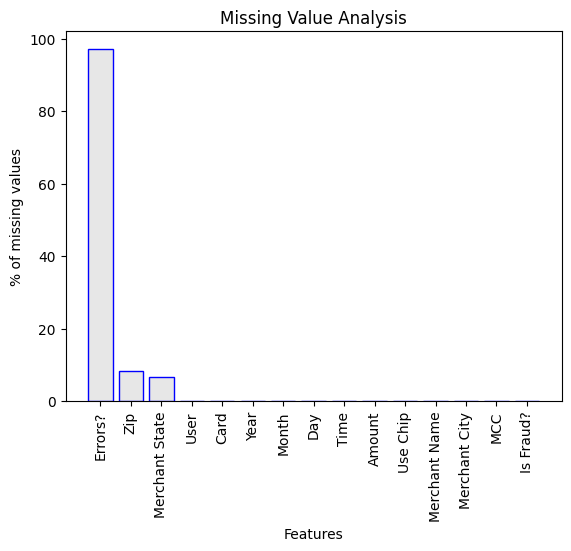

In [ ]:


percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)



In [ ]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [ ]:


df.Amount.head(5)



,Amount
0,$134.09
1,$38.48
2,$120.34
3,$128.95
4,$104.71


In [ ]:


# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)



In [ ]:


# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]



In [ ]:
df.Hour

,Hour
0,06
1,06
2,06
3,17
4,06
...,...
19958,13
19959,11
19960,16
19961,16


In [ ]:


df.Minute



,Minute
0,21
1,42
2,22
3,45
4,23
...,...
19958,03
19959,58
19960,53
19961,30


In [ ]:


df = df.drop(["Time","User","Card"],axis=1)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19963 entries, 0 to 19962
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            19963 non-null  int64  
 1   Month           19963 non-null  int64  
 2   Day             19963 non-null  int64  
 3   Amount          19963 non-null  float64
 4   Use Chip        19963 non-null  object 
 5   Merchant Name   19963 non-null  int64  
 6   Merchant City   19963 non-null  object 
 7   Merchant State  18646 non-null  object 
 8   Zip             18316 non-null  float64
 9   MCC             19963 non-null  int64  
 10  Errors?         574 non-null    object 
 11  Is Fraud?       19963 non-null  object 
 12  card_id         19963 non-null  object 
 13  Hour            19963 non-null  object 
 14  Minute          19963 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 2.3+ MB


In [ ]:
df["Errors?"].unique()

array([nan, 'Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad PIN,Insufficient Balance', 'Bad Expiration',
       'Bad PIN,Technical Glitch', 'Bad Card Number', 'Bad CVV'],
      dtype=object)

In [ ]:


df["Errors?"]= df["Errors?"].fillna("No error")



In [ ]:


df = df.drop(columns=["Merchant State","Zip"],axis=1)



In [ ]:
# change the is fraud column to binary
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])



In [ ]:
df["Errors?"].unique()

array([7, 8, 6, 3, 4, 2, 5, 1, 0])

In [ ]:


df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19963 entries, 0 to 19962
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           19963 non-null  int64  
 1   Month          19963 non-null  int64  
 2   Day            19963 non-null  int64  
 3   Amount         19963 non-null  float64
 4   Use Chip       19963 non-null  int64  
 5   Merchant Name  19963 non-null  int64  
 6   Merchant City  19963 non-null  int64  
 7   MCC            19963 non-null  int64  
 8   Errors?        19963 non-null  int64  
 9   Is Fraud?      19963 non-null  int64  
 10  card_id        19963 non-null  object 
 11  Hour           19963 non-null  object 
 12  Minute         19963 non-null  object 
dtypes: float64(1), int64(9), object(3)
memory usage: 2.0+ MB


In [ ]:


# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')



In [ ]:
# Add edges and properties to the edges
for _, row in df.iterrows():
    # Create a variable for each properties for each edge

        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']


        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)


In [ ]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 557
Number of edges: 0


In [ ]:


# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

adj_matrix.shape



Exception ignored in: <function _xla_gc_callback at 0x7f8b5b7941f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


(557, 557)

In [ ]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")

Node: 0_0, Properties: card_id
Node: 0_1, Properties: card_id
Node: 0_2, Properties: card_id
Node: 0_3, Properties: card_id
Node: 0_4, Properties: card_id
Node: 3527213246127876953, Properties: merchant_name
Node: -727612092139916043, Properties: merchant_name
Node: 3414527459579106770, Properties: merchant_name
Node: 5817218446178736267, Properties: merchant_name
Node: -7146670748125200898, Properties: merchant_name


In [ ]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2002,), 'month': (9,), 'day': (1,), 'hour': ('06',), 'minute': ('21',), 'amount': (134.09,), 'use_chip': (2,), 'merchant_city': (123,), 'errors': (7,), 'mcc': 5300}, 1: {'year': (2002,), 'month': (9,), 'day': (10,), 'hour': ('06',), 'minute': ('22',), 'amount': (102.18,), 'use_chip': (2,), 'merchant_city': (123,), 'errors': (7,), 'mcc': 5300}, 2: {'year': (2002,), 'month': (9,), 'day': (16,), 'hour': ('06',), 'minute': ('00',), 'amount': (115.34,), 'use_chip': (2,), 'merchant_city': (123,), 'errors': (7,), 'mcc': 5300}, 3: {'year': (2002,), 'month': (9,), 'day': (18,), 'hour': ('06',), 'minute': ('19',), 'amount': (128.85,), 'use_chip': (2,), 'merchant_city': (123,), 'errors': (7,), 'mcc': 5300}, 4: {'year': (2002,), 'month': (9,), 'day': (23,), 'hour': ('06',), 'minute': ('01',), 'amount': (134.89,), 'use_chip': (2,), 'merchant_city': (123,), 'errors': (7,), 'mcc': 5300}, 5: {'year': (2002,), 'month': (9,), 'day': (24,), 'hour': ('06',), 'minute': ('07',), 'amount': (112

In [ ]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")

Property value: (7,), Count: 19389
Property value: (6,), Count: 469
Property value: (3,), Count: 42
Property value: (8,), Count: 46
Property value: (4,), Count: 1
Property value: (2,), Count: 9
Property value: (5,), Count: 1
Property value: (1,), Count: 4
Property value: (0,), Count: 2


In [ ]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

list(edge_list[i][2].values())



[(2002,), (9,), (23,), ('06',), ('01',), (134.89,), (2,), (123,), (7,), 5300]

In [ ]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=301

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()



Epoch: 0, Loss: 0.17836011946201324
Epoch: 20, Loss: 1.1423512697219849
Epoch: 40, Loss: 1.2518786191940308
Epoch: 60, Loss: 1.1990901231765747
Epoch: 80, Loss: 1.1141728162765503
Epoch: 100, Loss: 1.0200347900390625
Epoch: 120, Loss: 0.9217157363891602
Epoch: 140, Loss: 0.8208556771278381
Epoch: 160, Loss: 0.7180184125900269
Epoch: 180, Loss: 0.6159682273864746
Epoch: 200, Loss: 0.5184710025787354
Epoch: 220, Loss: 0.4181223511695862
Epoch: 240, Loss: 0.31374773383140564
Epoch: 260, Loss: 0.2035548985004425
Epoch: 280, Loss: 0.08493868261575699
Epoch: 300, Loss: 0.032346099615097046


In [ ]:
!pip install torch-geometric



In [ ]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv


In [ ]:
# Global parameters:
embedding_size = 64
add_additional_data = True

In [ ]:
# we will take 70% of our dataset as traindata
cutoff = round(0.7*len(df))
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [ ]:
print('The distribution of fraud for the train data is:\n', train_data['Is Fraud?'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['Is Fraud?'].value_counts())

The distribution of fraud for the train data is:
 Is Fraud?
0    13949
1       25
Name: count, dtype: int64
The distribution of fraud for the inductive data is:
 Is Fraud?
0    5987
1       2
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Exemple de données (remplace cela par ton propre jeu de données)
# X_train, Y_train, X_val, Y_val sont des matrices numpy avec tes données
X_train = np.random.rand(11200, 10)  # Exemple avec 11200 échantillons et 10 caractéristiques
Y_train = np.random.rand(11200, 1)  # Valeurs cibles

X_val = np.random.rand(2800, 10)  # Validation data
Y_val = np.random.rand(2800, 1)  # Validation target

# Définir un modèle simple
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Définir l'optimiseur avec le nouveau paramètre 'learning_rate'
optimizer = Adam(learning_rate=0.001)

# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Entraîner le modèle
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, Y_val),
    verbose=1
)

# Manually compute accuracy for each epoch
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    print(f"Training loss: {history.history['loss'][epoch]:.4f} - Validation loss: {history.history['val_loss'][epoch]:.4f}")

    # Predictions on training and validation sets
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    # Calculate accuracy for training set
    train_accuracy = np.mean(np.round(train_predictions) == np.round(Y_train))
    # Calculate accuracy for validation set
    val_accuracy = np.mean(np.round(val_predictions) == np.round(Y_val))

    print(f"Training accuracy: {train_accuracy:.4f} - Validation accuracy: {val_accuracy:.4f}")



Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0989 - val_loss: 0.0838
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0860 - val_loss: 0.0828
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0827 - val_loss: 0.0841
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0834 - val_loss: 0.0824
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0843 - val_loss: 0.0826
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0821 - val_loss: 0.0820
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0831 - val_loss: 0.0821
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0830 - val_loss: 0.0817
Epoch 9/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0816 - val_loss: 0.0826
Epoch 10/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0820 - val_loss: 0.0819
Epoch 11/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0808 - val_loss: 0.0836
Epoch 12/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

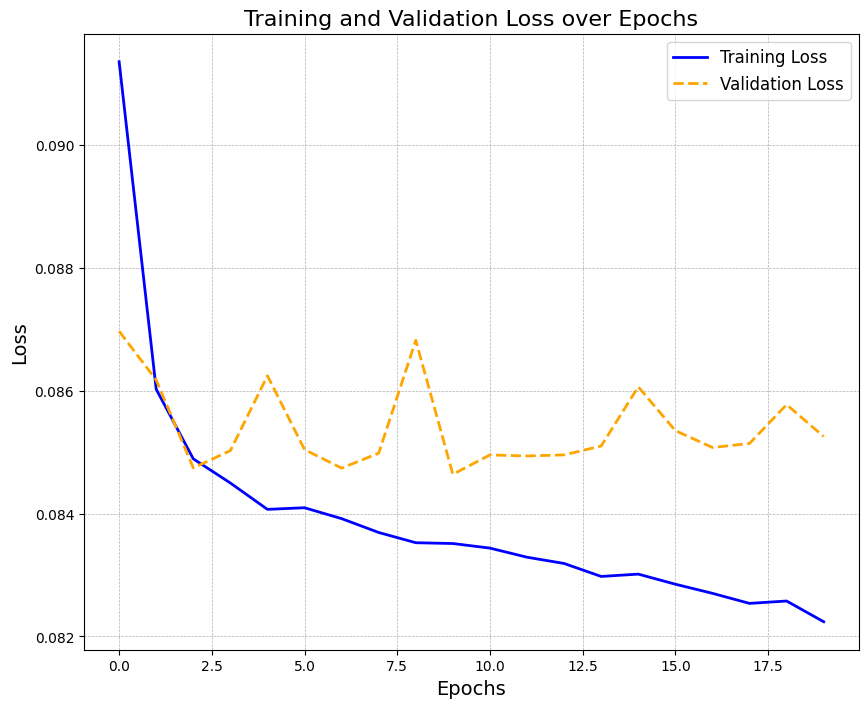

In [ ]:
import matplotlib.pyplot as plt

# Récupérer les pertes d'entraînement et de validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Créer un graphique
plt.figure(figsize=(10, 8))

# Tracer la courbe de la perte d'entraînement
plt.plot(train_loss, label='Training Loss', color='blue', linestyle='-', linewidth=2)

# Tracer la courbe de la perte de validation
plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)

# Ajouter un titre et des labels plus détaillés
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Afficher la légende et ajouter une grille
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Afficher le graphique
plt.show()


In [ ]:
!pip install --upgrade spektral



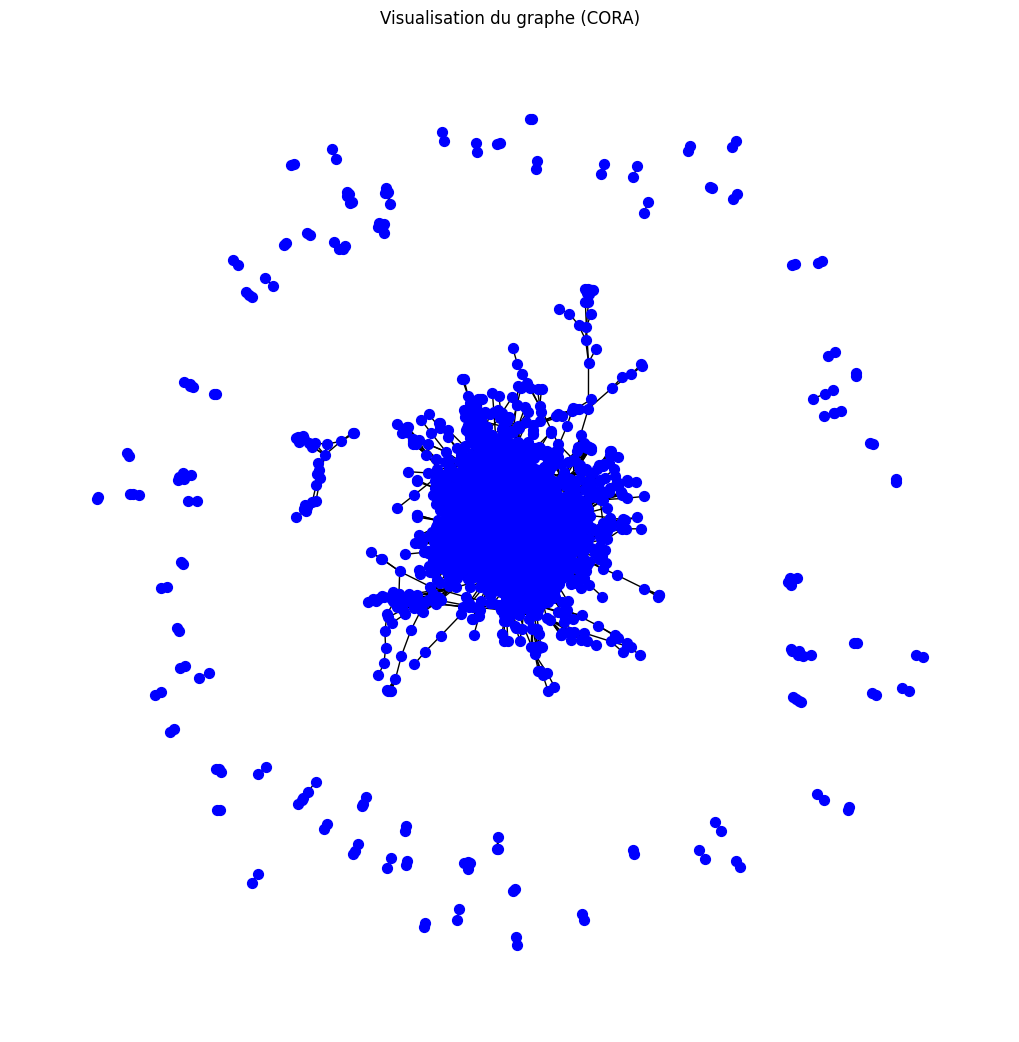

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from spektral.datasets import Citation

# Charger un exemple de graphe (graphe de citation)
dataset = Citation('cora')
graph = dataset[0]

# Conversion en graphe NetworkX pour visualisation
nx_graph = nx.from_scipy_sparse_array(graph.a)

# Tracer le graphe
plt.figure(figsize=(10, 10))
nx.draw(
    nx_graph,
    node_size=50,
    node_color='blue',
    with_labels=False,
    font_size=8
)
plt.title("Visualisation du graphe (CORA)")
plt.show()
